# Sound exploration

This is an introductory notebook with a bunch of examples of
- [x] loading sound files (especially .wav (aka .wave)) and comparing the speed
- [x] runnig the music with different sample rates
- [x] visualizing these sounds (representations)
    - [x] Sound wave
    - [x] Fourier transform
    - [x] STFT

In [5]:
import librosa

from pathlib import Path

## Load data

In this section i'll compare different frameworks for loading sounds:
* librosa
* scipy.io.wavfile

The output of these methods are sample rate and numpy array with the amplitude of each sample

In [17]:
from scipy.io import wavfile


def load_with_scipy(path: Path):
    sr, data = wavfile.read(path.as_posix())
    return sr, data


def load_with_librosa(path: Path):
    data, sr = librosa.load(path.as_posix())
    return sr, data

In [35]:
# sample audio file
# the speaker say "zero"
audio_path = Path("../data/fsdd/0_george_0.wav")

### Speed test on small file

For the first speed test let's use small files

#### scipy.io.wavfile

In [19]:
%%timeit -r 10 -n 100
_ = load_with_scipy(audio_path)

The slowest run took 6.18 times longer than the fastest. This could mean that an intermediate result is being cached.
47.7 µs ± 37.9 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


#### librosa

In [20]:
%%timeit -r 10 -n 100
_ = load_with_librosa(audio_path)

9.96 ms ± 296 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


Summary: scipy loads file 200 times faster

## Run music

To listen the sound one can use IPython Audio

### Run at native sample rate

In [31]:
from IPython.display import Audio, display

Audio(filename=audio_path)

### Downsample 

In [34]:
for sr in (1000, 5000, 10000):
    print("Sample rate:", sr)
    display(Audio(data=librosa.load(audio_path, sr=sr)[0], rate=sr))

Sample rate: 1000


Sample rate: 5000


Sample rate: 10000


## Visualization

### Sound wave

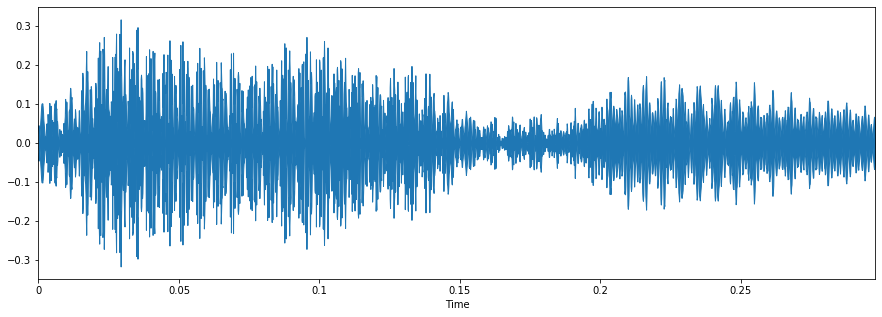

In [91]:
import librosa.display  # we have to import it explicitly to avoid error
import matplotlib.pyplot as plt


data, sr = librosa.load(audio_path, sr=None)

fig, ax = plt.subplots(figsize=(15, 5))
librosa.display.waveplot(data, sr=sr, ax=ax)

### Fourier transform

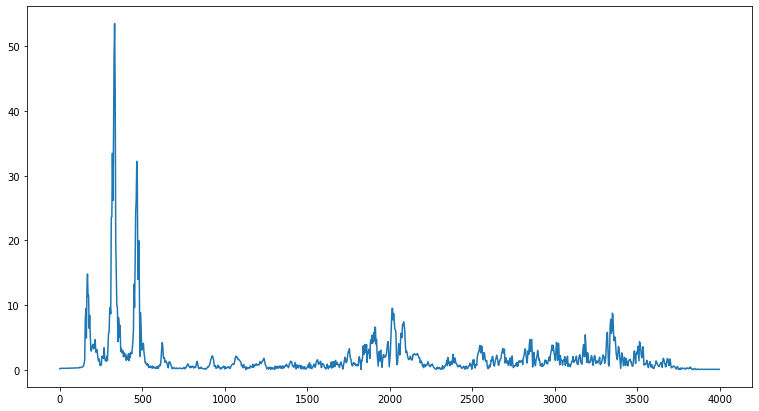

In [50]:
from scipy.fft import fft, fftfreq
import numpy as np

data, sr = librosa.load(audio_path, sr=None)
sp = 1 / sr
n_samples = data.shape[0]

yf = fft(data)[:n_samples//2]
frequencies = fftfreq(n_samples, sp)[:n_samples//2]

fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(frequencies, np.abs(yf))
ax.

## Spectrogram
aka STFT

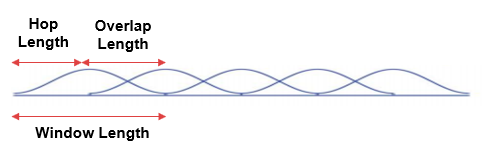

In [71]:
import math

def round_to_power2(x):
    return int(math.pow(2, math.ceil(math.log(x)/math.log(2))))

In [87]:
# desired window size in ms
window_size_ms = 25
window_size_samples = sr / window_size_ms / 2

# adjust window size to the next power of 2 integer for speed performance of fft
n_fft = round_to_power2(window_size_samples)
print(f"Window size corresponding to approx 25ms of audio with sr={sr} is {n_fft}")

win_length = n_fft
hop_length = win_length // 2  # which means that overlap is 50%

stft_matrix = librosa.stft(data, n_fft=n_fft, hop_length=hop_length)
print("Shape of stft matrix:", stft_matrix.shape)
print(f"Which means that there are {stft_matrix.shape[1]} windows with {n_fft} samples each out of {data.shape[0]} samples raw")

Window size corresponding to approx 25ms of audio with sr=8000 is 256
Shape of stft matrix: (129, 19)
Which means that there are 19 windows with 256 samples each out of 2384 samples raw


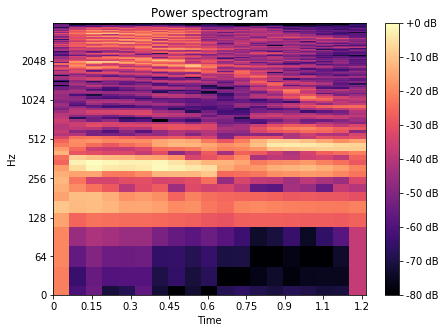

In [103]:
stft_amplitude = np.abs(stft_matrix)

fig, ax = plt.subplots(figsize=(7, 5))
img = librosa.display.specshow(
    data=librosa.amplitude_to_db(stft_amplitude, ref=np.max),
    sr=sr,
    y_axis="log", x_axis="time", ax=ax
)
ax.set_title("Power spectrogram")
fig.colorbar(img, ax=ax, format="%+2.0f dB")